# **Modelado**

En este notebook hacemos todo el proceso de fine-tuning de los 3 modelos diferente y evaluamos su performance.

# 0. Librerías 

In [1]:
import json
import os
import pandas as pd
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt



c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Datos preprocesados

In [2]:
df_train = pd.read_csv('../data/processed/train_encoded.csv')
df_val = pd.read_csv('../data/processed/validation_encoded.csv')
df_test = pd.read_csv('../data/processed/test_encoded.csv')

In [3]:
df_train.head()

,OriginalTweet,Sentiment
0,to everyone hoarding rice who until now doesnâ...,0
1,if your going to eat they have complementary w...,4
2,watch this if you are one of those idiots who ...,0
3,we need to have a risk management system more ...,3
4,markets plunge puts pension freedoms to the te...,3


In [4]:
df_val.head()

,OriginalTweet,Sentiment
0,meanwhile a villager of quenching her thirsty ...,2
1,us ethanol and biodiesel trends in prices and ...,3
2,today my husband came home from the supermarke...,4
3,so theres no cure for a virus than can be kill...,0
4,like the good new yorker i am i talked myself ...,4


In [5]:
df_test.head()

,OriginalTweet,Sentiment
0,trending new yorkers encounter empty supermark...,0
1,when i couldnt find hand sanitizer at fred mey...,3
2,find out how you can protect yourself and love...,4
3,buying hits city as anxious shoppers stock up ...,1
4,one week everyone buying baby milk powder the ...,2


# 2.  Modelado General

In [6]:
#### Funciones 

## 1. Tokenization

# Definimos función para tokenizar data. Seteamos max_length=128 de acuerdo a lo analizado en el EDA.
def tokenize_data(data, tokenizer):
    tokenized = tokenizer(data.astype(str).tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
    
    return tokenized

# Definimos función para tokenizar los datasets de train, val y test.
def tokenize_datasets(df_train, df_val, df_test, tokenizer):
    train_tokenized = tokenize_data(df_train['OriginalTweet'], tokenizer)
    val_tokenized = tokenize_data(df_val['OriginalTweet'], tokenizer)
    test_tokenized = tokenize_data(df_test['OriginalTweet'], tokenizer)
    
    return train_tokenized, val_tokenized, test_tokenized


## 2. Creción de TensorDatasets

# Función para convertir labels a tensores
def convert_to_tensor(df_train, df_val, df_test):
    labels_train = torch.tensor(df_train['Sentiment'])
    labels_val = torch.tensor(df_val['Sentiment'])
    labels_test = torch.tensor(df_test['Sentiment'])

    return labels_train, labels_val, labels_test

# Función para crear TensorDatasets a partir de los tweets tokenizados y el tensor de las etiquetas
def create_tensordatasets(train_tokenized, labels_train, val_tokenized, labels_val, test_tokenized, labels_test):
    train_dataset = TensorDataset(train_tokenized['input_ids'], train_tokenized['attention_mask'], labels_train)
    val_dataset = TensorDataset(val_tokenized['input_ids'], val_tokenized['attention_mask'], labels_val)
    test_dataset = TensorDataset(test_tokenized['input_ids'], test_tokenized['attention_mask'], labels_test)

    return train_dataset, val_dataset, test_dataset


## 3. Creación de DataLoaders

# Función para crear los DataLoaders de cada dataset
def create_dataloader(train_dataset,val_dataset,test_dataset, batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader


## 4. Calculamos Función de pérdida

# Función para calcular función de pérdida
def calculate_loss_fn(labels_train, device):
    # Calculamos los pesos para ponderar la función de pérdida para mitigar el desbalance de clases en el dataset original
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.numpy()), y=labels_train.numpy())
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Definimos la función de pérdida
    loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

    return loss_fn


## 5. Entrenamiento del modelo

# Función para entrenar el modelo
def train_model(model, optimizer, loss_fn,  train_dataloader, val_dataloader, epochs, device):

    # definimos scheduler
    scheduler = get_scheduler(
        name="linear", 
        optimizer=optimizer, 
        num_warmup_steps=0, 
        num_training_steps=epochs * len(train_dataloader)
    )

    # Entrenamiento
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Seteamos modo training
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_dataloader, desc="Entrenando"):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()

            # Forward
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            # Backward
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Actualizamos métricas
            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = train_loss / len(train_dataloader)
        acc = correct / total
        print(f"Train Loss: {avg_loss:.4f} | Train Accuracy: {acc:.4f}")

        # Validación
        # Seteamos modo de evaluación
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, labels)

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_dataloader)
        val_acc = correct / total
        print(f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_acc:.4f}")


## 6. Guardamos el modelo y el tokenizer

# Función para guardar modelo y tokenizer
def save_model_tokenizer(model, tokenizer,save_path):
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)



## 7. Evaluación del modelo en el dataset de test

# Función para guardar los experimentos realizados
def save_experiment_results(model_name, hyperparams, y_test, y_test_pred, encoder, output_path):
    # Calculamos métricas
    acc = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    report = classification_report(y_test, y_test_pred, target_names=encoder.categories_[0], output_dict=True)

    # Creamos registro del experimento
    experiment = {
        "modelo": model_name,
        "hiperparametros": hyperparams,
        "accuracy": round(acc, 4),
        "f1_macro": round(f1_macro, 4),
        "reporte_clasificacion": report
    }

    # Guardamos en archivo .json (agrega múltiples experimentos)
    if os.path.exists(output_path):
        with open(output_path, "r", encoding="utf-8") as f:
            results = json.load(f)
    else:
        results = []

    results.append(experiment)

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=4, ensure_ascii=False)

    print(f"### Resultados del experimento guardados en {output_path}")


def evaluate_model(model, model_name,hyperparams, test_dataloader, device, path_encoder,output_path):
    # Cargamos el encoder
    encoder = joblib.load(path_encoder)

    # Seteamos modo de evaluación
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print('#### Resultados de Evaluacion #### \n\n')
    print(classification_report(all_labels, all_preds, target_names=encoder.categories_[0]))

    print('\n')
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.categories_[0])
    disp.plot(xticks_rotation=45)
    plt.show()

    # Guardamos métricas del experimento
    save_experiment_results(
    model_name,
    hyperparams,
    y_test=all_labels,
    y_test_pred=all_preds,
    encoder=encoder,
    output_path = output_path
    )

In [7]:
##### 8. Función para ejecutar y orquestar todo el pipeline de entrenamiento

def execute_modeling_pipeline(df_train, df_val, df_test, model_name,  lr, weight_decay, batch_size, epochs, save_path, device, save_model=False):
    
    print(f'#### Pipeline para el modelo {model_name} iniciado #### \n')

    ## 1. Tokenization

    # Inicializamos el tokenizer para el modelo seleccionado
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenizamos los datasets
    train_tokenized, val_tokenized, test_tokenized = tokenize_datasets(df_train, df_val, df_test, tokenizer)

    print('### Proceso de Tokenization finalizado ### \n')


    ## 2. Creación de TensorDataset, objetos necesarios para trabajar en pytorch

    # Convertimos la etiqueta, Sentiment, en tensores
    labels_train, labels_val, labels_test = convert_to_tensor(df_train, df_val, df_test)

    # Creamos los TensorDataset a partir de los tweets tokenizados y el tensor de las etiquetas
    train_dataset, val_dataset, test_dataset = create_tensordatasets(train_tokenized, labels_train, val_tokenized, labels_val, test_tokenized, labels_test)


    ## 3. Creación de DataLoaders

    # Definimos los dataloaders para entregar los TensorDataset a pytorch por batches
    train_dataloader, val_dataloader, test_dataloader = create_dataloader(train_dataset,val_dataset,test_dataset, batch_size)

    print('### Dataloaders Creados ### \n')


    ## 4. Función de pérdida

    # Calculamos la función de pérdida ponderada
    loss_fn =  calculate_loss_fn(labels_train, device)

    print('### Función de pérdida calculada ### \n')


    ## 5. Entrenamiento del modelo especificado

    print(f'### Inicio de Fine-Tuning del modelo {model_name} ### \n')
    
    # Definimos el modelo
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, return_dict=True)
    model.to(device)
    print("\n")

    # Definimos optimizer
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


    # Entrenamos el modelo
    train_model(model, optimizer, loss_fn,  train_dataloader, val_dataloader, epochs=epochs, device=device)

    print(f'\n\n### Fin de Fine-Tuning del modelo {model_name} ### \n')

    ## 6. Guardamos el modelo entrenado para posterior evaluación en dataset de test

    # Guardamos el estado actual del modelo y el tokenizer
    if save_model:
        save_model_tokenizer(model, tokenizer, save_path)

        print(f'### Modelo finetuneado y tokenizer guardado en {save_path} ### \n')

    return model, test_dataloader

# 3. Modelado de BERT

In [8]:
## Definimos parámetros del modelado
hyperparams = {
'model_name' : 'bert-base-uncased',
'lr':3e-5,
'weight_decay':1e-4,
'batch_size' : 4,
'epochs': 3,
'save_path': "../models/bert_sentiment_analysis_model"
}

# Seteamos uso de gpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Ejecutamos el pipeline de entrenamiento
model, test_dataloader = execute_modeling_pipeline(df_train, df_val, df_test, *hyperparams.values(), device, save_model=True)


#### Pipeline para el modelo bert-base-uncased iniciado #### 

### Proceso de Tokenization finalizado ### 

### Dataloaders Creados ### 

### Función de pérdida calculada ### 

### Inicio de Fine-Tuning del modelo bert-base-uncased ### 



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 1/3


Entrenando: 100%|██████████| 8232/8232 [1:05:27<00:00,  2.10it/s]   


Train Loss: 0.7053 | Train Accuracy: 0.7157
Val Loss: 0.5979 | Val Accuracy: 0.7640
Epoch 2/3


Entrenando: 100%|██████████| 8232/8232 [49:02<00:00,  2.80it/s]  


Train Loss: 0.3418 | Train Accuracy: 0.8757
Val Loss: 0.3796 | Val Accuracy: 0.8680
Epoch 3/3


Entrenando: 100%|██████████| 8232/8232 [33:01<00:00,  4.15it/s]  


Train Loss: 0.1775 | Train Accuracy: 0.9388
Val Loss: 0.3833 | Val Accuracy: 0.8720


### Fin de Fine-Tuning del modelo bert-base-uncased ### 

### Modelo finetuneado y tokenizer guardado en ../models/bert_sentiment_analysis_model ### 



#### Resultados de Evaluacion #### 


                    precision    recall  f1-score   support

Extremely Negative       0.85      0.93      0.89       592
          Negative       0.87      0.82      0.84      1041
           Neutral       0.84      0.88      0.86       619
          Positive       0.84      0.81      0.82       947
Extremely Positive       0.87      0.88      0.87       599

          accuracy                           0.85      3798
         macro avg       0.85      0.86      0.86      3798
      weighted avg       0.85      0.85      0.85      3798





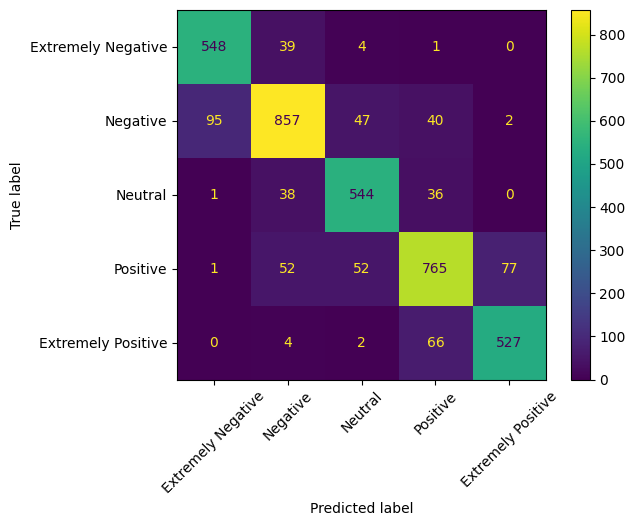

### Resultados del experimento guardados en ../outputs/resultados_experimentos.json


In [9]:
# Evaluamos el modelo BERT
path_encoder= '../models/ordinal_encoder.pkl'
output_path = '../outputs/resultados_experimentos.json'

evaluate_model(model,hyperparams['model_name'], hyperparams, test_dataloader, device, path_encoder,output_path)

# 4. Modelado de RoBERTa

In [10]:
## Definimos parámetros del modelado
hyperparams = {
'model_name' : 'roberta-base',
'lr':3e-5,
'weight_decay':1e-4,
'batch_size' : 4,
'epochs': 3,
'save_path': "../models/roberta_sentiment_analysis_model"
}

# Seteamos uso de gpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Ejecutamos el pipeline de entrenamiento
model, test_dataloader = execute_modeling_pipeline(df_train, df_val, df_test, *hyperparams.values(), device, save_model=True)

#### Pipeline para el modelo roberta-base iniciado #### 

### Proceso de Tokenization finalizado ### 

### Dataloaders Creados ### 

### Función de pérdida calculada ### 

### Inicio de Fine-Tuning del modelo roberta-base ### 



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 1/3


Entrenando: 100%|██████████| 8232/8232 [33:34<00:00,  4.09it/s]  


Train Loss: 1.6107 | Train Accuracy: 0.2406
Val Loss: 1.6083 | Val Accuracy: 0.2409
Epoch 2/3


Entrenando: 100%|██████████| 8232/8232 [41:08<00:00,  3.33it/s]  


Train Loss: 1.6098 | Train Accuracy: 0.2516
Val Loss: 1.6081 | Val Accuracy: 0.2776
Epoch 3/3


Entrenando: 100%|██████████| 8232/8232 [1:16:49<00:00,  1.79it/s]    


Train Loss: 1.5806 | Train Accuracy: 0.2660
Val Loss: 1.4865 | Val Accuracy: 0.2781


### Fin de Fine-Tuning del modelo roberta-base ### 

### Modelo finetuneado y tokenizer guardado en ../models/roberta_sentiment_analysis_model ### 



#### Resultados de Evaluacion #### 


                    precision    recall  f1-score   support

Extremely Negative       0.30      0.85      0.45       592
          Negative       0.33      0.00      0.01      1041
           Neutral       0.26      0.88      0.40       619
          Positive       0.38      0.01      0.01       947
Extremely Positive       0.00      0.00      0.00       599

          accuracy                           0.28      3798
         macro avg       0.25      0.35      0.17      3798
      weighted avg       0.27      0.28      0.14      3798





c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

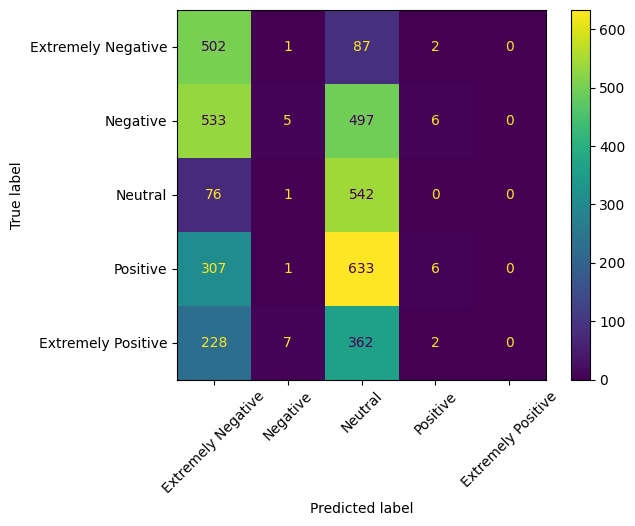

c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Resultados del experimento guardados en ../outputs/resultados_experimentos.json


c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [11]:
# Evaluamos el modelo RoBERTa
evaluate_model(model,hyperparams['model_name'], hyperparams, test_dataloader, device, path_encoder,output_path)

# 5. Modelado de DistilBERT

In [12]:
## Definimos parámetros del modelado
hyperparams = {
'model_name' : 'distilbert-base-uncased',
'lr':3e-5,
'weight_decay':1e-4,
'batch_size' : 4,
'epochs': 3,
'save_path': "../models/distilbert_sentiment_analysis_model"
}

# Seteamos uso de gpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

# Ejecutamos el pipeline de entrenamiento
model, test_dataloader = execute_modeling_pipeline(df_train, df_val, df_test, *hyperparams.values(), device, save_model=True)

#### Pipeline para el modelo distilbert-base-uncased iniciado #### 

### Proceso de Tokenization finalizado ### 

### Dataloaders Creados ### 

### Función de pérdida calculada ### 

### Inicio de Fine-Tuning del modelo distilbert-base-uncased ### 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 1/3


Entrenando: 100%|██████████| 8232/8232 [27:52<00:00,  4.92it/s]     


Train Loss: 0.6894 | Train Accuracy: 0.7151
Val Loss: 0.4744 | Val Accuracy: 0.8110
Epoch 2/3


Entrenando: 100%|██████████| 8232/8232 [39:17<00:00,  3.49it/s]     


Train Loss: 0.3450 | Train Accuracy: 0.8732
Val Loss: 0.4362 | Val Accuracy: 0.8284
Epoch 3/3


Entrenando: 100%|██████████| 8232/8232 [34:36<00:00,  3.96it/s]     


Train Loss: 0.1849 | Train Accuracy: 0.9361
Val Loss: 0.3931 | Val Accuracy: 0.8670


### Fin de Fine-Tuning del modelo distilbert-base-uncased ### 

### Modelo finetuneado y tokenizer guardado en ../models/distilbert_sentiment_analysis_model ### 



#### Resultados de Evaluacion #### 


                    precision    recall  f1-score   support

Extremely Negative       0.85      0.91      0.88       592
          Negative       0.83      0.82      0.83      1041
           Neutral       0.87      0.86      0.87       619
          Positive       0.82      0.80      0.81       947
Extremely Positive       0.86      0.88      0.87       599

          accuracy                           0.84      3798
         macro avg       0.85      0.85      0.85      3798
      weighted avg       0.84      0.84      0.84      3798





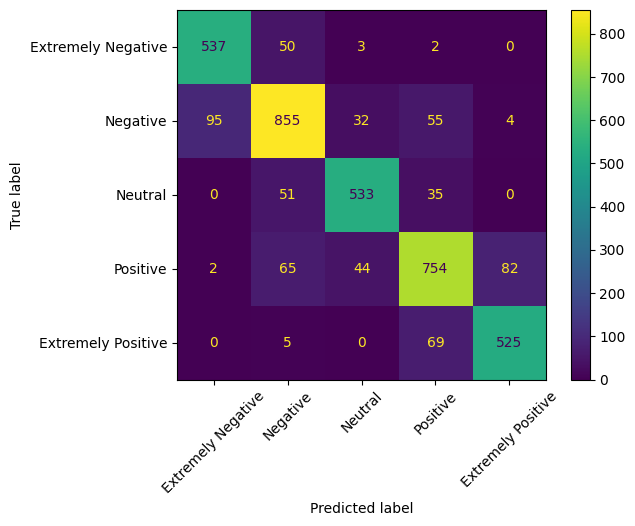

### Resultados del experimento guardados en ../outputs/resultados_experimentos.json


In [13]:
# Evaluamos el modelo DistilBERT
evaluate_model(model,hyperparams['model_name'], hyperparams, test_dataloader, device, path_encoder,output_path)

# 6. Conclusiones

## 6.1 BERT

- Al observar la evolución del entrenamiento del modelo a lo largo de los tres epochs, notamos que tanto `loss` como el `accuracy` mejoran consistentemente con cada iteración. Esto es una señal clara de que el modelo está aprendiendo de manera efectiva y, de momento, no estamos experimentando un underfitting.

- Sin embargo, hay un detalle importante a considerar: en el último epoch, el valor de pérdida en el conjunto de validación muestra un ligero aumento en comparación con el epoch anterior, mientras que el valor de pérdida en el conjunto de entrenamiento sigue disminuyendo. Esta divergencia sugiere que podríamos estar adentrándonos en una zona de overfitting. 

- Al analizar la evaluación en el data de test del modelo BERT después de haberle realizado el proceso de fine-tuning, se obtienen resultados excelentes:

    - `accuracy promedio = 0.85`: Esto implica que en el 85% de las predicciones realizadas sobre datos *no observados*, el modelo clasificó correctamente los tweets en su respectiva clase de `Sentiment`.

    - `F1-score macro = 0.86`, `F1-score weighted = 0.85`: Estos valores indican un rendimiento sólido y consistente en todas las clases de `Sentiment`. Esto evidencia la efectidad de la función de pérdida ponderada cálculada, ya que equilibra el aprendizaje del modelo preveniendo sesgos por las clases mayoritarias.

- En resumen, el fine-tuning del modelo BERT presenta un performance muy bueno, demostrado por su alta capacidad de clasificar con alta precisión la clase de `Sentiment` de cada tweet.

## 6.2 RoBERTa

- Al análizar las métricas de `loss` y `accuracy` durante el entrenamiento del modelo, se observa que mas métricas mejoran a medida que hacemos las epochs. Esto indica que el modelo aprende y no entra ni en overfitting ni underfitting.

- Sin emabrgo, lás metricas de `F1-Score` y `Accuracy` están ambas por debajo de 0.30, lo cual indica un pésimo desempeño del modelo tanto en los datos de train, val, como en datos no observados previamente.

## 6.3 DistilBERT

- Este modelo presenta un performance excelente, muy similar al del modelo BERT. Durante el proceso de entrenamiento se evidencia el aprendizaje del modelo epoch tras epoch, sin caer ni en zona de under o overfitting, mostrado por el mejoramiento de ambas métricas `loss` y `accuracy` en cada iteración.

- El `F1-Score macro = 0.85` y `Avg Accuracy = 0.84` evidencian de nuevo la robustez y precisión del modelo fine-tuneado para clasificar los tweets según su clase.

 En este proyecto implementamos una metodología robusta y replicable para el entrenamiento de clasificadores de texto por medio del fine-tuning de modelos Transformers pre-entrenados, enfocándonos en la tarea de análisis de tweets y su respectiva clasificación de "sentimiento". A través de un pipeline modular se logró entrenar y evaluar distintos modelos como BERT, DistilBERT y RoBERTa, obteniendo resultados sobresalientes. En particular, se alcanzó un accuracy del 85% y un F1-score macro de 86% para BERT y DistilBERT, lo cual evidencia un excelente desempeño general y un balance en la clasificación entre categorías.